# Youtube Trending Video Statistics and Prediction

Youtube publishes a list of top trending videos on its website daily. It uses a number of factors like number of views, comments, likes, shares, etc. to determine the trending videos. In this tutorial I will analyze the data on Youtube Trending videos in USA between Nov 2017 and Mar 2018. 

I will try to understand the pattern on type of videos trending, distribution of likes, dislikes, views, comments, most viewed youtube channels, common tags and words, etc. I will also try to create different features with the dataset and use them to predict the number of days a video could remain trending on Youtube USA. Thus the takeaway of this tutorial will be to get some exposure to exploratory data analysis and visulaization of unseen data, and modeling the dataset to classify/predict some useful information.

The dataset files consists of a csv and a json file and can be downloaded from dropbox hosted at https://www.dropbox.com/sh/cuqk03n2sqn5rvq/AACdn2yqXqe017ZtBbm3kmsPa?dl=0. It is orginially taken from Kaggle, the link for which can be found in refrences. I have used only the US data in this tutorial.


In [1]:
import pandas as pd
import nltk
import re
import string
import collections

Let us start by uploading the csv data as dataframe in this notebook and peek on how data looks like.

In [2]:
df_usa_daily=pd.read_csv("youtube-new/USvideos.csv")
df_usa_daily.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


Now let us look if this data have missing values in any of the columns. I will delete the rows which have missing values in crucial columns like title, trending_data, channel_title, category_id, etc. For other missing value columns such as description, and tags I will just fill empty strings.

In [3]:
print(df_usa_daily.isnull().any())
df_usa_daily.drop(df_usa_daily[df_usa_daily['channel_title'].isnull() & df_usa_daily['category_id'].isnull()].index, inplace = True)
df_usa_daily.fillna("", inplace = True)
# to verify that our data has no more missing values
print(df_usa_daily.isnull().any())

video_id                  False
trending_date             False
title                     False
channel_title             False
category_id               False
publish_time              False
tags                      False
views                     False
likes                     False
dislikes                  False
comment_count             False
thumbnail_link            False
comments_disabled         False
ratings_disabled          False
video_error_or_removed    False
description                True
dtype: bool
video_id                  False
trending_date             False
title                     False
channel_title             False
category_id               False
publish_time              False
tags                      False
views                     False
likes                     False
dislikes                  False
comment_count             False
thumbnail_link            False
comments_disabled         False
ratings_disabled          False
video_error_or_removed    Fa

We may need Publish_time and Trending_date data in Date-Time format for our convenience and easy manipulation

In [4]:
df_usa_daily['publish_time']=pd.to_datetime(df_usa_daily['publish_time'])
df_usa_daily['trending_date']=pd.to_datetime(df_usa_daily['trending_date'], format='%y.%d.%m')

## Data Modelling and Feature Engineering

In the above dataframe, we have data on youtube trending videos on daily basis. However, a video can be featured as trending on multiple days, thus giving us duplicates in the above dataframe.

Therefore, we will now convert our dataframe by
1. Sorting data on trending_date.
2. Grouping by video_id to get only one row of a particular video.
3. Taking likes, dislikes, comment_count of the last day the video was trending, since this value will be cumulative of previous entries.
4. Creating a column "trendingDays" which will give us the number of days a particular video was trending on YouTube USA.

In [5]:
# sort data
df_usa_daily = df_usa_daily.sort_values(['video_id', 'trending_date'])

# group by video_id and take size of the group
df_usa_trendingDays = df_usa_daily.groupby(['video_id']).size()

# drop duplicates, keeping the last value of the sorted dataframe
df_usa_top = df_usa_daily.drop_duplicates(subset='video_id', keep='last', inplace=False)

# add trendingDays using groupby object
df_usa_top['trendingDays'] = df_usa_top.apply(lambda x: df_usa_trendingDays.loc[x['video_id']], axis =1)

# sort by descending trendingDays
df_usa_top = df_usa_top.sort_values(['trendingDays'], ascending = False)

# set video_id as index
df_usa_top.set_index('video_id', drop = False)

# peek the new dataframe
df_usa_top.head(3)

/Users/anirudhagarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,trendingDays
23753,H0g4JxKp4fc,2018-03-14,*cough*,jacksfilms,23,2018-02-26 19:00:02,"Jacksfilms|""Jack Douglass""|""YGS""|""YGS 100""|""YG...",2305537,225422,8704,41490,https://i.ytimg.com/vi/H0g4JxKp4fc/default.jpg,False,False,False,"If you like those shirts, you can get em here ...",16
23756,CwKp6Xhy3_4,2018-03-14,Chris Young - Hangin' On,ChrisYoungVEVO,10,2018-02-26 08:00:02,"Losing sleep video|""losing sleep album""|""think...",1606993,9035,693,343,https://i.ytimg.com/vi/CwKp6Xhy3_4/default.jpg,False,False,False,Chris Young's Hangin' On from his #1 album Los...,16
24749,4HU6Z7anycw,2018-03-19,Lucas the Spider - Polar Bear,Lucas the Spider,1,2018-03-04 00:32:18,"LucastheSpider|""Animation""|""3D Animation""|""VFX...",6106813,292251,5483,17562,https://i.ytimg.com/vi/4HU6Z7anycw/default.jpg,False,False,False,Don't worry...Dexter is a spider friendly pup!...,16


## Data Analysis and Visualization

Now let us do exploratory data analysis by visualizing some aspects of the data such as
1. Top videos: Videos with largest trending time
2. Top Youtube channels: channels which published most trending videos
3. Top category: Category with most trending videos
4. Word Cloud: for tags and description
5. Oldest trending: Duration between published date and last trending date.
6. Likes and Dislikes count vs Comments Count
7. Day of week: when most videos trend on Youtube
8. Day and Hour: when most videos are published on Youtube.

For many of these visualizations, we will create features as and when we analyze that part of data.


### Top Videos

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

largest_trending=df_usa_top[["title","trendingDays"]].sort_values(by="trendingDays",ascending=False)
largest_trending.set_index("title",inplace=True)
largest_trending = largest_trending.head(25)

plt.style.use('ggplot')
sb.set(rc={"figure.figsize":(10,10)})
largest_trending.plot.barh(color='c')
plt.title("25 Largest Trending Videos on YouTube")
plt.xlabel("trending days")

Text(0.5,0,'trending days')

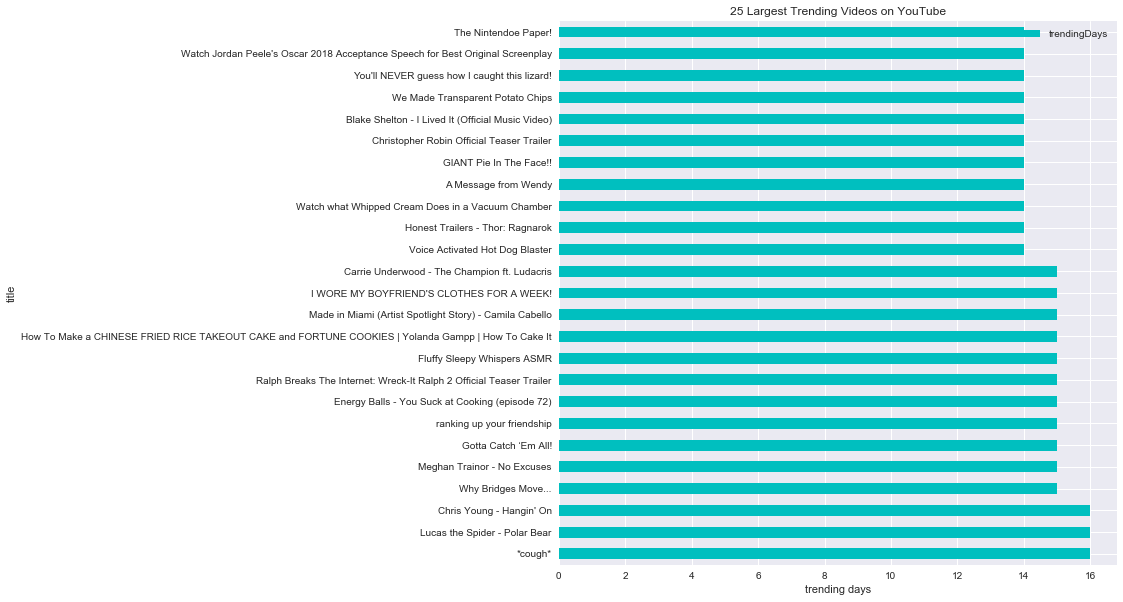

In [7]:
plt.show()

### Top Youtube channels

In [8]:
top_channels=df_usa_top[["channel_title"]]
top_channels = top_channels.groupby(['channel_title']).size().sort_values(ascending=False)
top_channels = top_channels.head(25)

plt.figure(figsize=(8,8))
top_channels.plot.barh(color='g')
plt.title("Top 25 channels on Youtube USA")
plt.xlabel("number of trending videos in past 5 months")

Text(0.5,0,'number of trending videos in past 5 months')

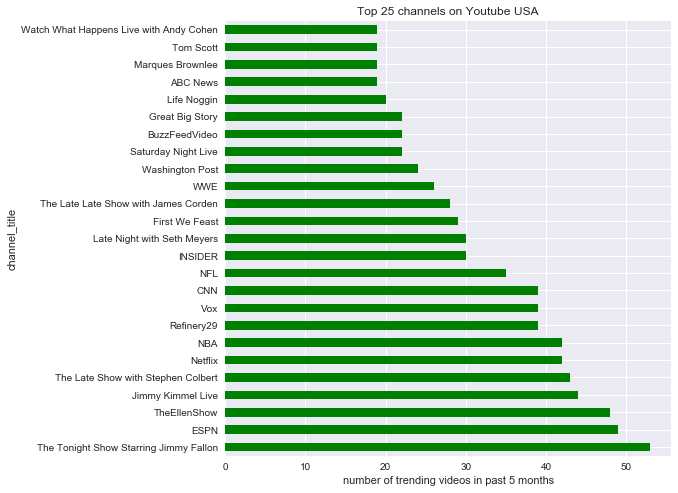

In [9]:
plt.show()

### Top Categories 

We have category_names for each category_id available to us seprately as a json file. Therefore we will read this json file and merge category_names to above dataframe

In [10]:
import json

category_dict = {}
with open("youtube-new/US_category_id.json") as categories:
    data=json.load(categories)
    for category in data["items"]:
        category_dict[category["id"]]=category["snippet"]["title"]
        
df_usa_top["Category"]=(df_usa_top["category_id"].astype(str)).map(category_dict)

Now, let us see visualize which categories have the most trending videos.

In [11]:
top_categories=df_usa_top[["Category"]]
top_categories = top_categories.groupby(['Category']).size().sort_values(ascending=False)
top_categories = top_categories.head(25)

plt.figure(figsize=(8,8))
top_categories.plot.barh()
plt.title("Top video Categories on Youtube")
plt.xlabel("number of trending videos in past 5 months")

Text(0.5,0,'number of trending videos in past 5 months')

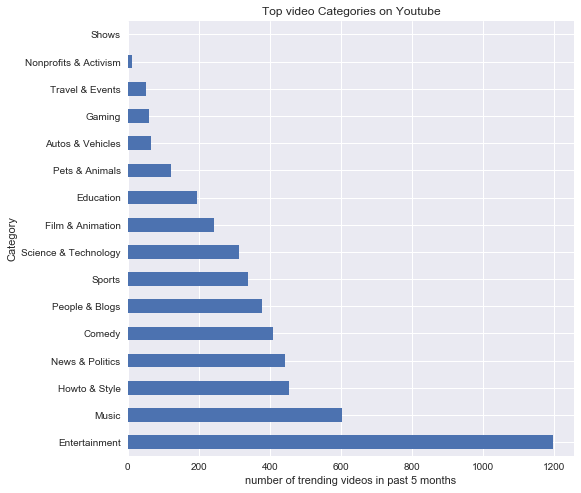

In [12]:
plt.show()

As we can see above, number of videos in entertainment category outbeats any other category. Therefore our data is highly skewed on categories.

### Word Cloud
A word cloud is an image composed of words used in a particular text, in which the size of each word indicates its frequency or importance.

Let us see the most used tags using word cloud

Here is how the tags columns in our dataframe looks like

In [13]:
df_usa_top["tags"].head(3)

23753    Jacksfilms|"Jack Douglass"|"YGS"|"YGS 100"|"YG...
23756    Losing sleep video|"losing sleep album"|"think...
24749    LucastheSpider|"Animation"|"3D Animation"|"VFX...
Name: tags, dtype: object

To create a word cloud, we first need to join tags for all the videos, remove all the punctuations and stopwords

In [14]:
def flat_tags(tags):
    for punctuation in string.punctuation: 
        tags= tags.replace(punctuation," ")
    return tags

df_usa_top["tags"] = df_usa_top["tags"].apply(flat_tags)

tags = df_usa_top['tags'].str.lower().str.cat(sep=' ')

stop_words = nltk.corpus.stopwords.words('english')

tags = nltk.word_tokenize(tags)
for tag in stop_words:
    while tag in tags: tags.remove(tag)

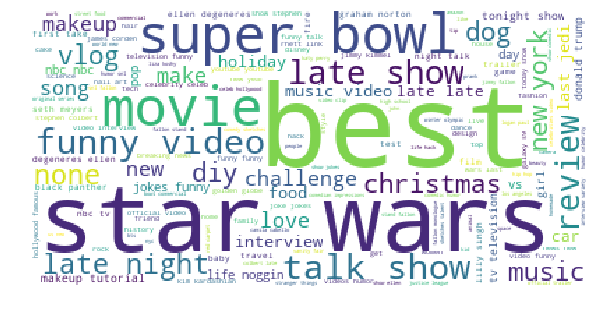

In [15]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=200,
                         ).generate(' '.join(tags))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From this Word cloud, we can see that super bowl, star wars, movie are some of the most frequent tags used on Youtube USA

Similarly, we can create a word cloud for most frequent words in description. Since publishers put links in description all the time, we will remove words like https, www, bit etc for our word cloud.

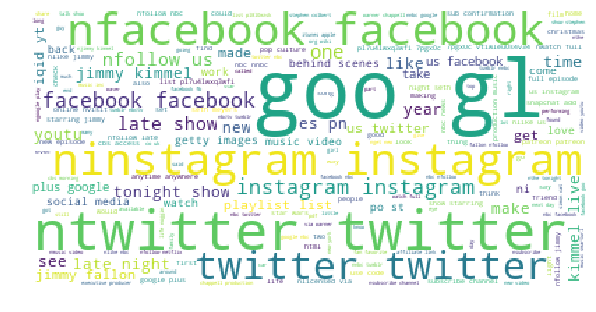

In [16]:
description = df_usa_top['description'].str.lower().str.cat(sep='  ')

for punctuation in string.punctuation:
        description= description.replace(punctuation," ")

description = nltk.word_tokenize(description)

stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['https', 'youtube','bit', 'ly', 'nhttp', 'nhttps', 'http', 'www', 'com'])

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=300,
                         ).generate(' '.join(description))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Oldest trending videos
It might be interesting to see which videos were trending much later than they we actually published on Youtube.

In [17]:
df_usa_top['peak_life'] = (df_usa_top['trending_date'] - df_usa_top['publish_time']).astype('timedelta64[D]')

max_peak_life=df_usa_top[['peak_life', 'title']].sort_values(by='peak_life',ascending=False)
max_peak_life.set_index("title",inplace=True)
max_peak_life = max_peak_life.head(25)

plt.figure(figsize=(8,8))
max_peak_life.plot.barh()
plt.title("Oldest videos trending on Youtube")
plt.xlabel("Days between publish and trending dates")

Text(0.5,0,'Days between publish and trending dates')

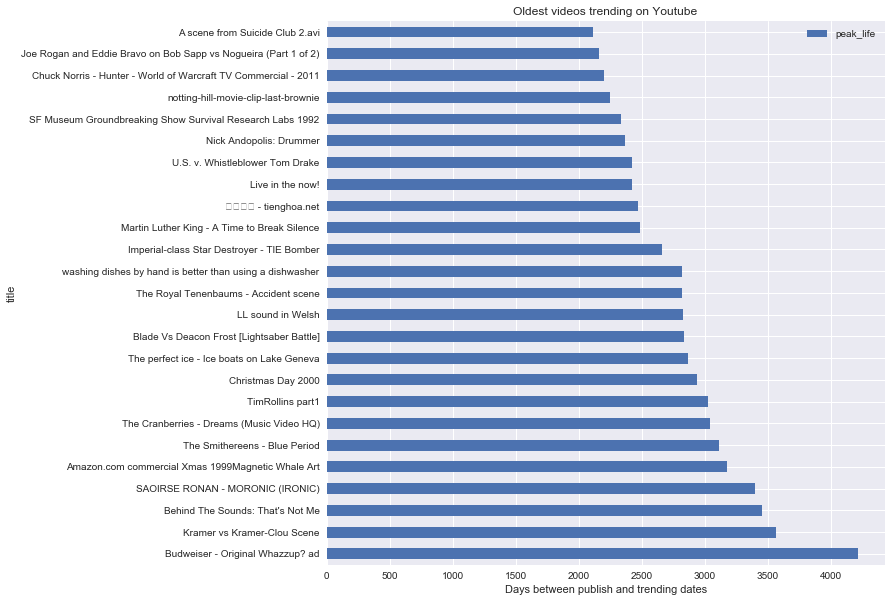

In [18]:
plt.show()

So this means the Budweiser Original Whazzup ad is trending on youtube after more than 4000 days, i.e. around 11 years

### Likes and Dislikes count vs Comments Count

Let us analyze what is the general ratio of likes and disklikes count vs the comments count on youtube videos

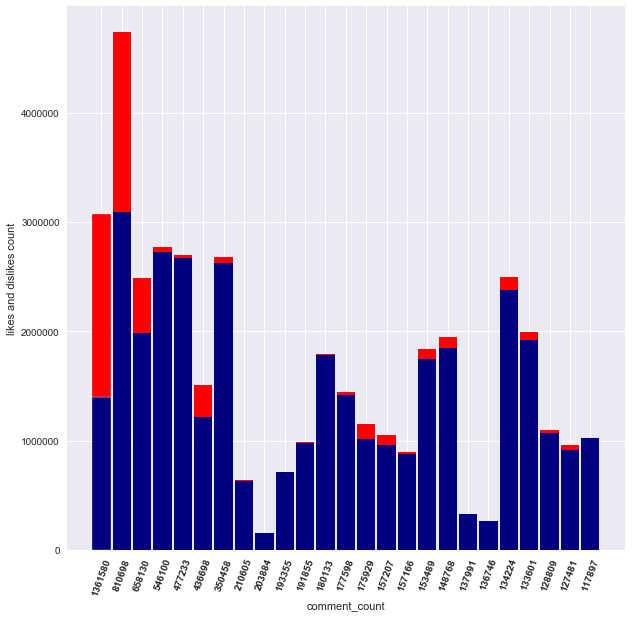

In [53]:
from matplotlib import rc

df_usa_top_comments = df_usa_top.sort_values(['comment_count'], ascending = False)
top25_comment_count = df_usa_top_comments['comment_count'].head(25)
top25_comment_like_count = df_usa_top_comments['likes'].head(25)
top25_comment_dislike_count = df_usa_top_comments['dislikes'].head(25)
barWidth = 0.9
r = list(range(25))
## Create like bars
plt.bar(r, top25_comment_like_count, color='navy', edgecolor='white', width=barWidth)
## Create dislike bars stacked on like bars
plt.bar(r, top25_comment_dislike_count, bottom=top25_comment_like_count, color='red', edgecolor='white', width=barWidth)
plt.xticks(r, top25_comment_count, fontweight='bold', rotation=70)
plt.xlabel("comment_count")
plt.ylabel("likes and dislikes count")
plt.show()



As we can see from the above plot, dislikes increases as comments increases, but there is no general trend with likes on a video.

### Day of week when most videos trend on Youtube

Let us see what day of a week videos on youtube have a high trending rate.

In [20]:
df_usa_top["Trending_Day_of_Week"]=df_usa_top["trending_date"].dt.weekday_name
day_of_week = df_usa_top[["Trending_Day_of_Week"]]
top_weekday = day_of_week.groupby(['Trending_Day_of_Week']).size().sort_values(ascending=False)

plt.figure(figsize=(8,8))
top_weekday.plot.bar(color='c')
plt.title("Top days of week for videos")
plt.xlabel("weekday")

Text(0.5,0,'weekday')

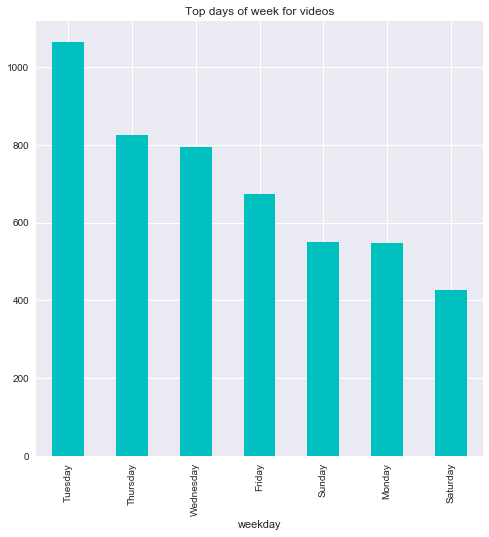

In [21]:
plt.show()

### Day and Hour when most videos are published on Youtube.

It might also be interesting to analyze when most publishers tend to put their video on Youtube. 

In [22]:
df_usa_top["Publish_Day_of_Week"]=df_usa_top["publish_time"].dt.weekday_name
day_of_week = df_usa_top[["Publish_Day_of_Week"]]
top_weekday = day_of_week.groupby(['Publish_Day_of_Week']).size().sort_values(ascending=False)

plt.figure(figsize=(8,8))
top_weekday.plot.bar(color='y')
plt.title("Top days of week to publish videos")
plt.xlabel("weekday")


Text(0.5,0,'weekday')

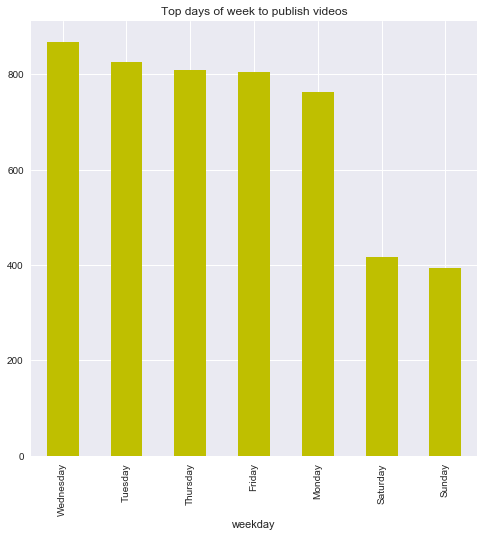

In [23]:
plt.show()

Interestingly more videos are published on weekdays than weekends

In [24]:
#df_usa_top["Publish_Day_of_Week"]=df_usa_top["publish_time"].dt.weekday_name
df_usa_top["Publish_Hour"] = df_usa_top["publish_time"].apply(lambda x: x.hour)
publish_hr = df_usa_top[["Publish_Hour"]]
publish_hr = publish_hr.groupby(['Publish_Hour']).size().sort_values(ascending=False)

plt.figure(figsize=(8,8))
publish_hr.plot.bar(color='y')
plt.title("Top hour of day to publish videos")
plt.xlabel("day hours")



Text(0.5,0,'day hours')

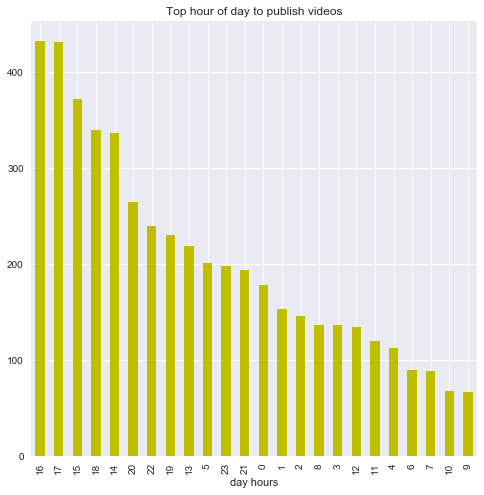

In [25]:
plt.show()

As expected, most videos are published in evening hours.

## Trending Days Prediction

Let us first convert trendingDays into a categorical variable. One way of doing this is to categorize trending days into less than 3 days, 3-7 days, 7-10 days, and more than 10 days.

In [26]:
def calcTrendingTime(trendDays):
    if trendDays<=3:
        return 1
    elif trendDays<=7:
        return 2
    elif trendDays<=10:
        return 3
    else:
        return 4
df_usa_top['trending_label'] = df_usa_top['trendingDays'].apply(calcTrendingTime)

Now, let us have a look at what columns we can use in our prediction model.

In [27]:
df_usa_top.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'trendingDays', 'Category',
       'peak_life', 'Trending_Day_of_Week', 'Publish_Day_of_Week',
       'Publish_Hour', 'trending_label'],
      dtype='object')

For our model, we can use only numerical features and categorical features

In [28]:
#numerical features
columns_numeric = ['category_id', 'views', 'likes', 'dislikes', 'Publish_Hour', 
                   'comments_disabled', 'ratings_disabled', 'trending_label']

In [29]:
# categorical features
columns_categorical = ['Trending_Day_of_Week', 'Publish_Day_of_Week', 'Category']

To use tags in our model, we will use only top 100 tags on Youtube. If a video contains this tag, the corresponding tag column will have a value 1 for that video

In [30]:
import operator
tag_coutner = collections.Counter(tags)
sorted_tag_coutner = sorted(tag_coutner.items(), key=operator.itemgetter(1), reverse=True)

top_tags = [k for k, v in sorted_tag_coutner[:100]]

for col in top_tags:
    df_usa_top[col] = 0
    for index, row in df_usa_top.iterrows():
        if col in row['tags']:
            df_usa_top[col] = 1
columns_categorical.extend(top_tags)  

Let us create a new dataframe with all these features. For our categorical features, we need to create dummy variables

In [31]:
df = df_usa_top[columns_numeric]
dummies = pd.get_dummies(df_usa_top[columns_categorical])
df = pd.concat([df, dummies], axis = 1)

We will divide our data into 70% training and 30% test set

In [32]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'trending_label'], df['trending_label'], test_size = 0.3, train_size = 0.7)

/Users/anirudhagarwal/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Finally, we will use Random forest classifier to train and predict the trending_label for our data.

A random forest fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The features are always randomly permuted at each split.

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_class = rf.predict(X_test)

To evaluate our model, we can calculate accuracy, recall, and precision, f1-score

In [41]:
from sklearn import metrics

metrics.accuracy_score(y_test, y_pred_class)

0.6013651877133106

In [42]:
print(metrics.classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          1       0.55      0.62      0.58       479
          2       0.65      0.74      0.69       743
          3       0.44      0.18      0.26       176
          4       0.11      0.01      0.03        67

avg / total       0.57      0.60      0.57      1465



This means with our model, we are getting around 60% of predictions correct with an average recall of 0.60. As we can notice, the scores are good for trending_label 1 and 2 but not for 3 and 4. This is because our data is skewed as we have large amount of data for lower trending days but small data for high trending days.

In [36]:
size1 = len(df_usa_top[df_usa_top['trending_label'] == 1])
size2 = len(df_usa_top[df_usa_top['trending_label'] == 2])
size3 = len(df_usa_top[df_usa_top['trending_label'] == 3])
size4 = len(df_usa_top[df_usa_top['trending_label'] == 4])

In [37]:
print('Size of trending_label 1: ', size1)
print('Size of trending_label 2: ', size2)
print('Size of trending_label 3: ', size3)
print('Size of trending_label 4: ', size4)

Size of trending_label 1:  1607
Size of trending_label 2:  2440
Size of trending_label 3:  561
Size of trending_label 4:  273


## References:

To understand the approach to explolatory data analysis, I looked into many datasets and kernels published on kaggle. This gave me some idea on how to approach any data and determine useful parts of it, and how to use different visualizing libraries. References that I used in particluar are:
1. https://www.kaggle.com/datasnaek/youtube-new
2. http://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/
3. https://www.kaggle.com/quannguyen135/what-is-trending-on-youtube-eda-with-python
4. https://www.kaggle.com/amarjeet91/youtube-insights-in-python-eda
5. https://www.kaggle.com/ankkur13/sentiment-analysis-nlp-wordcloud-textblob
6. https://python-graph-gallery.com/12-stacked-barplot-with-matplotlib/
7. https://www.analyticsvidhya.com/blog/2017/09/common-machine-learning-algorithms/
8. https://medium.com/@InDataLabs/why-start-a-data-science-project-with-exploratory-data-analysis-f90c0efcbe49

Dataset on Kaggle:
https://www.kaggle.com/datasnaek/youtube-new/data